<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/Short_term_crypto_mean_reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crypto Short Term Mean Reversion

This notebook supports this webinar: https://robotwealth.com/rw-pro-update-2024-04-24-investigating-crypto-reversal-effects/

In [5]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', "glue", "tibbletime","roll","RcppRoll","Rcpp", "patchwork"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installationThe following packages are out of date:

• dbplyr  (2.4.0 -> 2.5.0)
• ggplot2 (3.4.4 -> 3.5.1)
• ragg    (1.2.5 -> 1.3.0)
• rvest   (1.0.3 -> 1.0.4)

Start a clean R session then run:
install.packages(c("dbplyr", "ggplot2", "ragg", "rvest"))


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




bit        (4.0.4 -> 4.0.5) [CRAN]
tidyselect (1.2.0 -> 1.2.1) [CRAN]
assertthat (NA    -> 0.2.1) [CRAN]


Installing 3 packages: bit, tidyselect, assertthat

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpLIDxHW/remotes5a054005c83/RWLab-rwRtools-e73b39d/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.68.tar.gz’



# Prepare Universe for trading

Mostly copying Kris's existing code here.

In [7]:
# snippet: rw data auth v.0.1
rwlab_data_auth()
# load binance prices
prices <- rwRtools::crypto_get_binance_spot_1h()

Authorization successful!

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 914 Mb )





File successfully transferred


Remove stuff we don't want. (just copying this from kris's trend notebook)

In [9]:
# remove LUNAUSDT from Friday 13 May 2022. Even though it continued to exist after this, there's no way you'd include it in your universe of tradable assets.
prices <- prices %>%
  filter(!(Ticker == "LUNAUSDT" & Datetime >= "2022-05-13"))

prices %>% head

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETHUSDT,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETHUSDT,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETHUSDT,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


Make a sensible universe - remove stables, wrapped coins, leveraged tokens. Take top n by rolling 30-day dollar volume.

In [10]:
library(httr)

# ditch stables and wrapped/leveraged tokens and keep only the data we need

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

stables <- glue::glue("{stables}USDT")

# duplicates and others to remove
to_remove <- glue::glue("{c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')}USDT")

# Remove stablecoins and others
prices <- prices %>%
  filter(!Ticker %in% c(stables, to_remove)) %>%
  mutate(Ticker = str_replace(Ticker, "USDT$", ""))

head(prices)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTC,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETH,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTC,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETH,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTC,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETH,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


In [11]:
# limit universe
trading_universe_size <- 50

universe <- prices %>%
  # just get the top n by trailing 30-day volume
  group_by(Ticker) %>%
  mutate(trail_volume = roll::roll_mean(`Quote asset volume`, 30*24)) %>%
  na.omit() %>%
  group_by(Datetime) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  )

head(universe)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,trail_volume,volume_rank,is_universe
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2017-09-16 09:00:00,3816.03,3839.75,3753.00,3753.08,76.39284,288969.0,431,19.24200,72926.08,145466.23,1,TRUE
ETH,2017-09-16 09:00:00,264.99,267.00,255.00,256.00,510.07931,133181.1,490,164.07393,42691.10,78536.56,2,TRUE
BTC,2017-09-16 10:00:00,3753.29,3753.29,3470.66,3480.00,175.25183,627740.7,778,58.97698,209869.88,146057.03,1,TRUE
ETH,2017-09-16 10:00:00,256.00,257.96,235.51,240.00,1385.45880,340142.1,697,349.70160,86958.16,78956.64,2,TRUE
BTC,2017-09-16 11:00:00,3490.00,3678.22,3490.00,3630.06,113.72828,409920.0,475,68.05315,246000.25,146487.05,1,TRUE
ETH,2017-09-16 11:00:00,241.00,252.00,236.11,249.99,555.04440,137007.9,387,304.23427,75306.66,78988.53,2,TRUE


Resample data to daily observations

In [12]:
daily <- universe %>%
  group_by(Ticker) %>%
  mutate(date = floor_date(Datetime, 'day')) %>%
  group_by(Ticker, date) %>%
  arrange(Datetime) %>%
  summarize(
    price = last(Close),
    high = max(High),
    low = min(Low),
    volume = last(Volume),
    volume_rank = last(volume_rank),
    is_universe =  last(is_universe)
  )

  daily %>% tail()

`summarise()` has grouped output by 'Ticker'. You can override using the
`.groups` argument.


Ticker,date,price,high,low,volume,volume_rank,is_universe
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
ZRX,2024-03-22,0.8885,0.9778,0.8456,4946643,90,FALSE
ZRX,2024-03-23,0.8645,0.8785,0.8513,476599,87,FALSE
ZRX,2024-03-24,0.8594,0.9276,0.8376,411262,85,FALSE
ZRX,2024-03-25,0.9390,1.0511,0.9041,2842998,84,FALSE
ZRX,2024-03-26,1.0026,1.0914,0.9978,1181587,83,FALSE
ZRX,2024-03-27,1.0677,1.1542,1.0331,1077417,81,FALSE


Calculate distance from 3 day high

In [13]:
# Rolling days since high
rolling_days_since_high_3 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 3, na_value = NA),
  otherwise = NA
)

dsh <- daily %>%
  group_by(Ticker) %>%
  arrange(date) %>%
  mutate(dsh_3 = rolling_days_since_high_3(price))

dsh %>% tail()

Ticker,date,price,high,low,volume,volume_rank,is_universe,dsh_3
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<int>
YFI,2024-03-27,9274.00000,9283.00000,8717.00000,2.879287e+01,191,FALSE,0
YGG,2024-03-27,1.28980,1.36820,1.13520,5.152025e+06,66,FALSE,1
ZEC,2024-03-27,31.84000,32.00000,29.75000,5.592877e+03,228,FALSE,0
ZEN,2024-03-27,14.39000,14.46000,13.55000,7.146440e+03,227,FALSE,1
ZIL,2024-03-27,0.03761,0.03783,0.03467,1.490381e+07,107,FALSE,0
ZRX,2024-03-27,1.06770,1.15420,1.03310,1.077417e+06,81,FALSE,0


Warning message:
“Removed 388 rows containing non-finite values (`stat_count()`).”


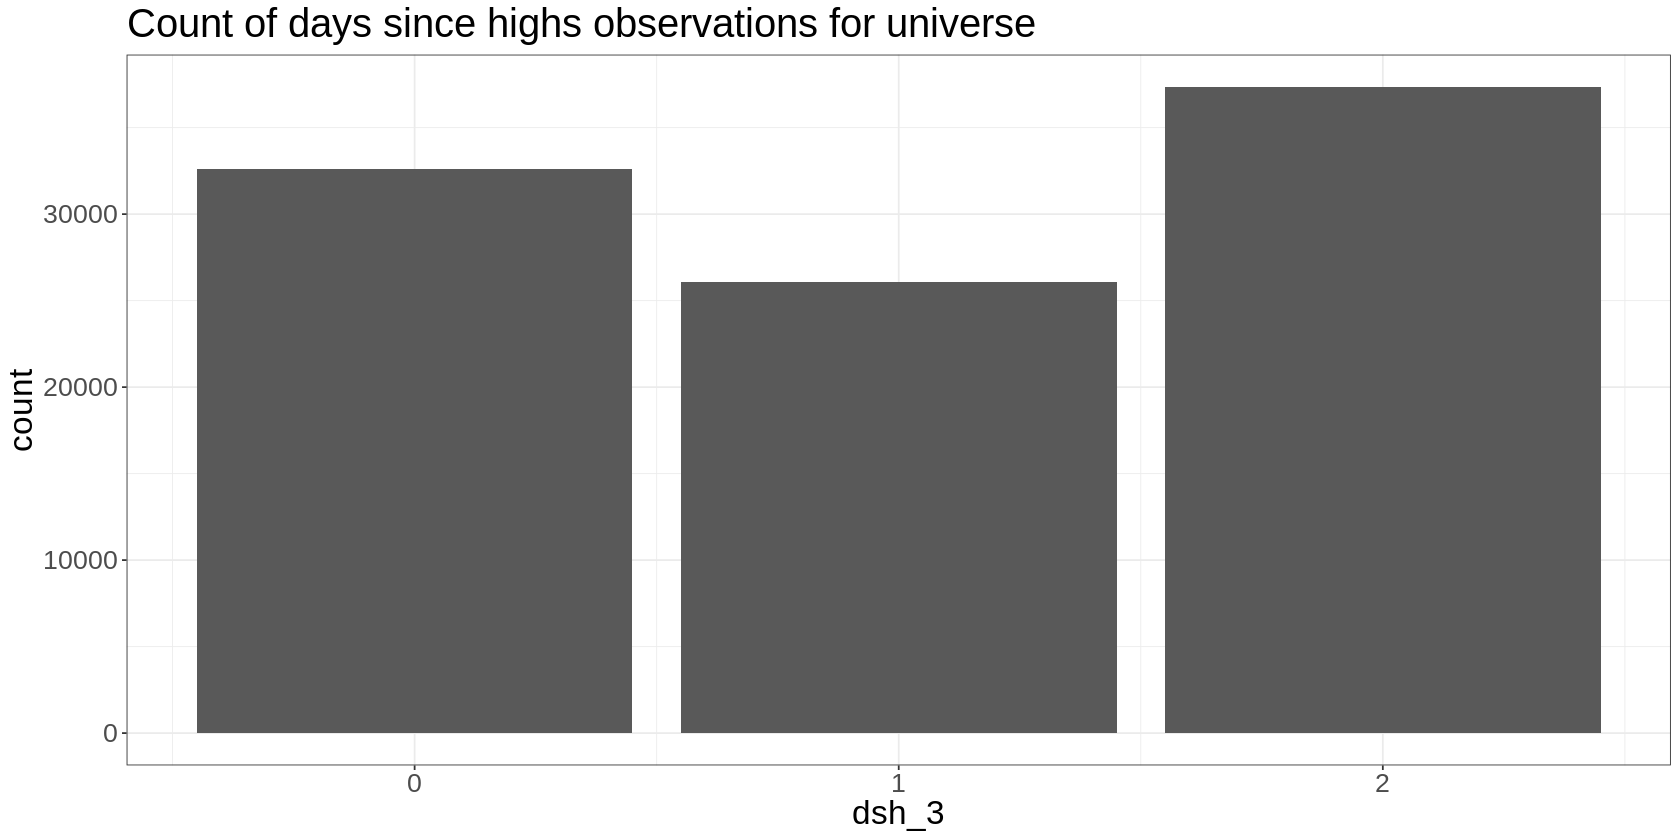

In [14]:
dsh %>%
  filter(is_universe) %>%
  ggplot(aes(x=dsh_3)) + geom_bar() +
  ggtitle('Count of days since highs observations for universe')

Our thesis is that we expect to see reversion following a coin making new 3 day highs...

so we should expect to see next day returns be lower for dsh_3 = 0 than the other observations.

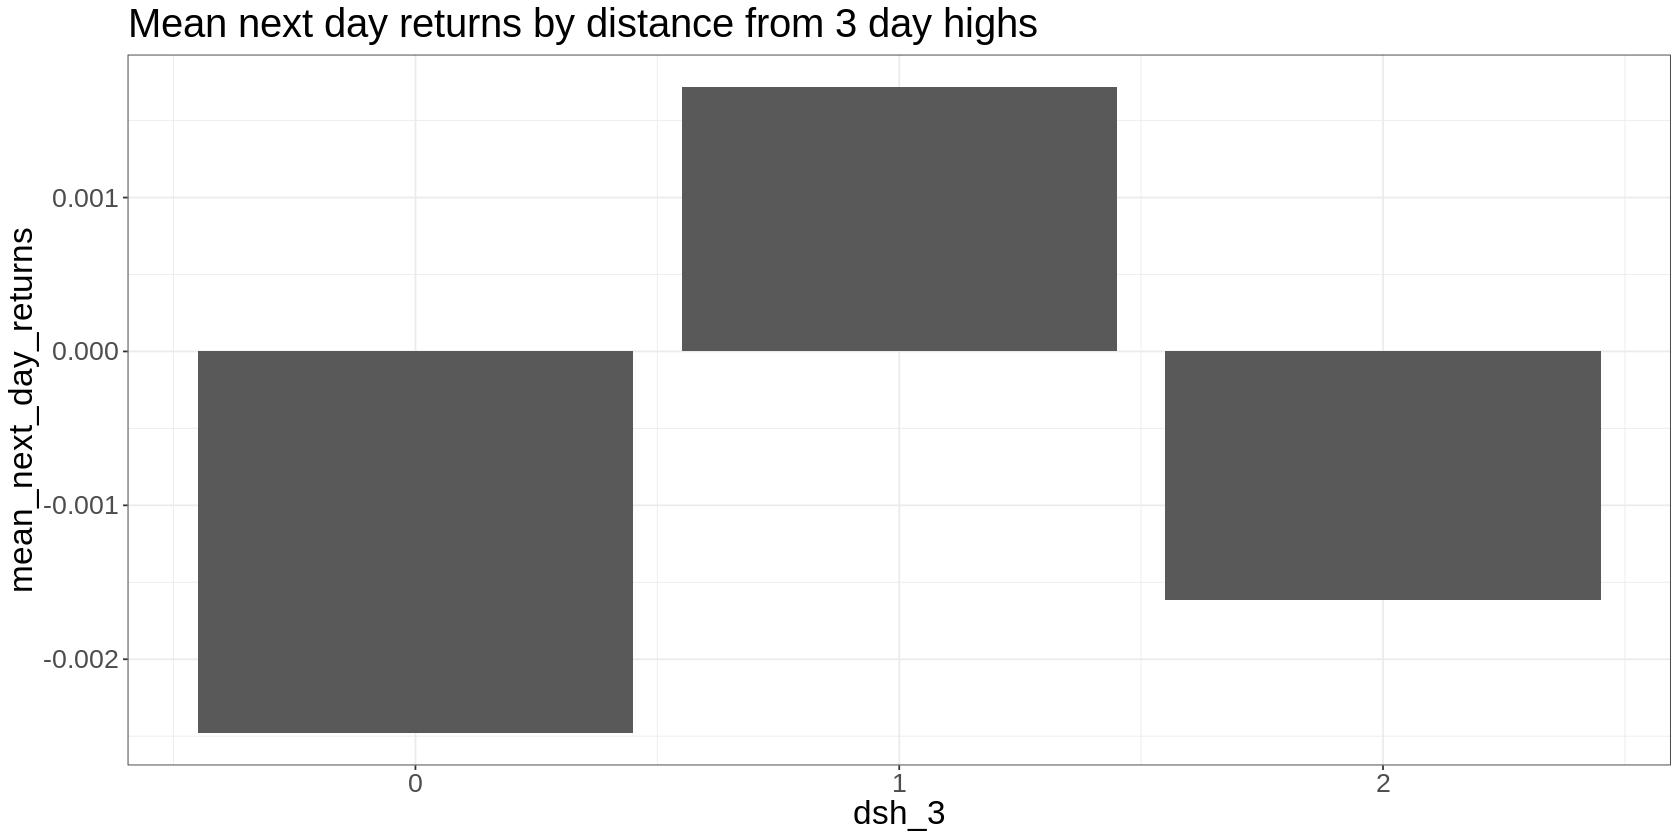

In [15]:
dsh %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = log(lead(price)/price)) %>%
  na.omit() %>%
  filter(is_universe) %>%
  group_by(dsh_3) %>%
  summarize(mean_next_day_returns = mean(next_day_returns)) %>%
  ggplot(aes(x=dsh_3, y = mean_next_day_returns)) + geom_bar(stat='identity') + ggtitle('Mean next day returns by distance from 3 day highs')

what does it look like on the other side?

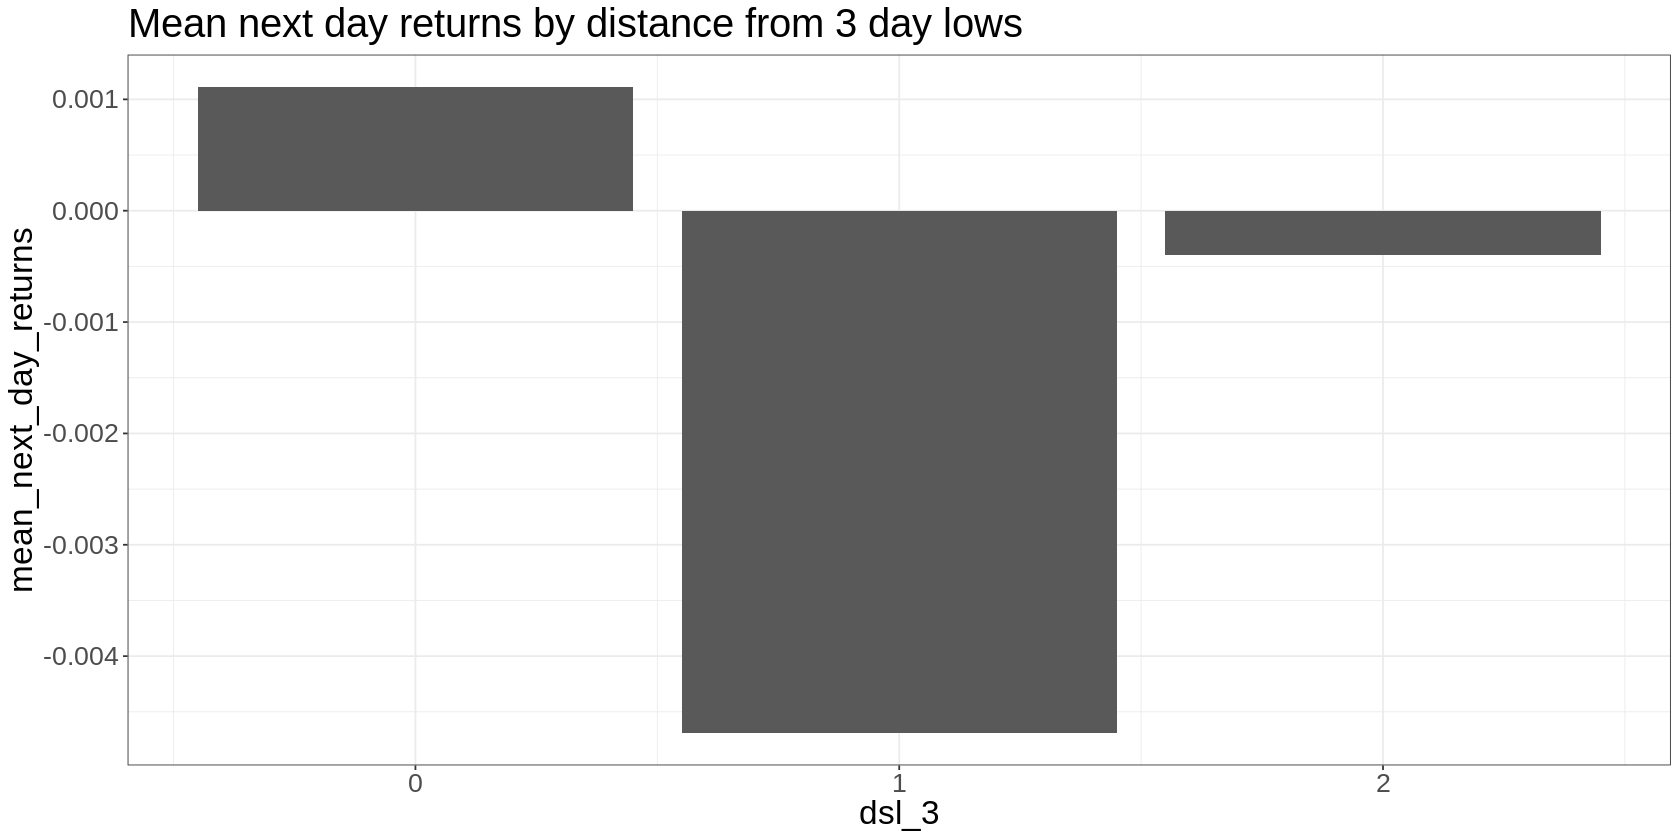

In [16]:
# Rolling days since high
rolling_days_since_low_3 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_low <- which.min(x)
      days_since_low <- length(x) - idx_of_low
      days_since_low
    },
    window = 3, na_value = NA),
  otherwise = NA
)

dsl <- daily %>%
  group_by(Ticker) %>%
  arrange(date) %>%
  mutate(dsl_3 = rolling_days_since_low_3(price))

dsl %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = log(lead(price)/price)) %>%
  na.omit() %>%
  filter(is_universe) %>%
  group_by(dsl_3) %>%
  summarize(mean_next_day_returns = mean(next_day_returns)) %>%
  ggplot(aes(x=dsl_3, y = mean_next_day_returns)) + geom_bar(stat='identity') + ggtitle('Mean next day returns by distance from 3 day lows')


We do see a weak kinda reversion effect

What would it look like if we just faded everything?

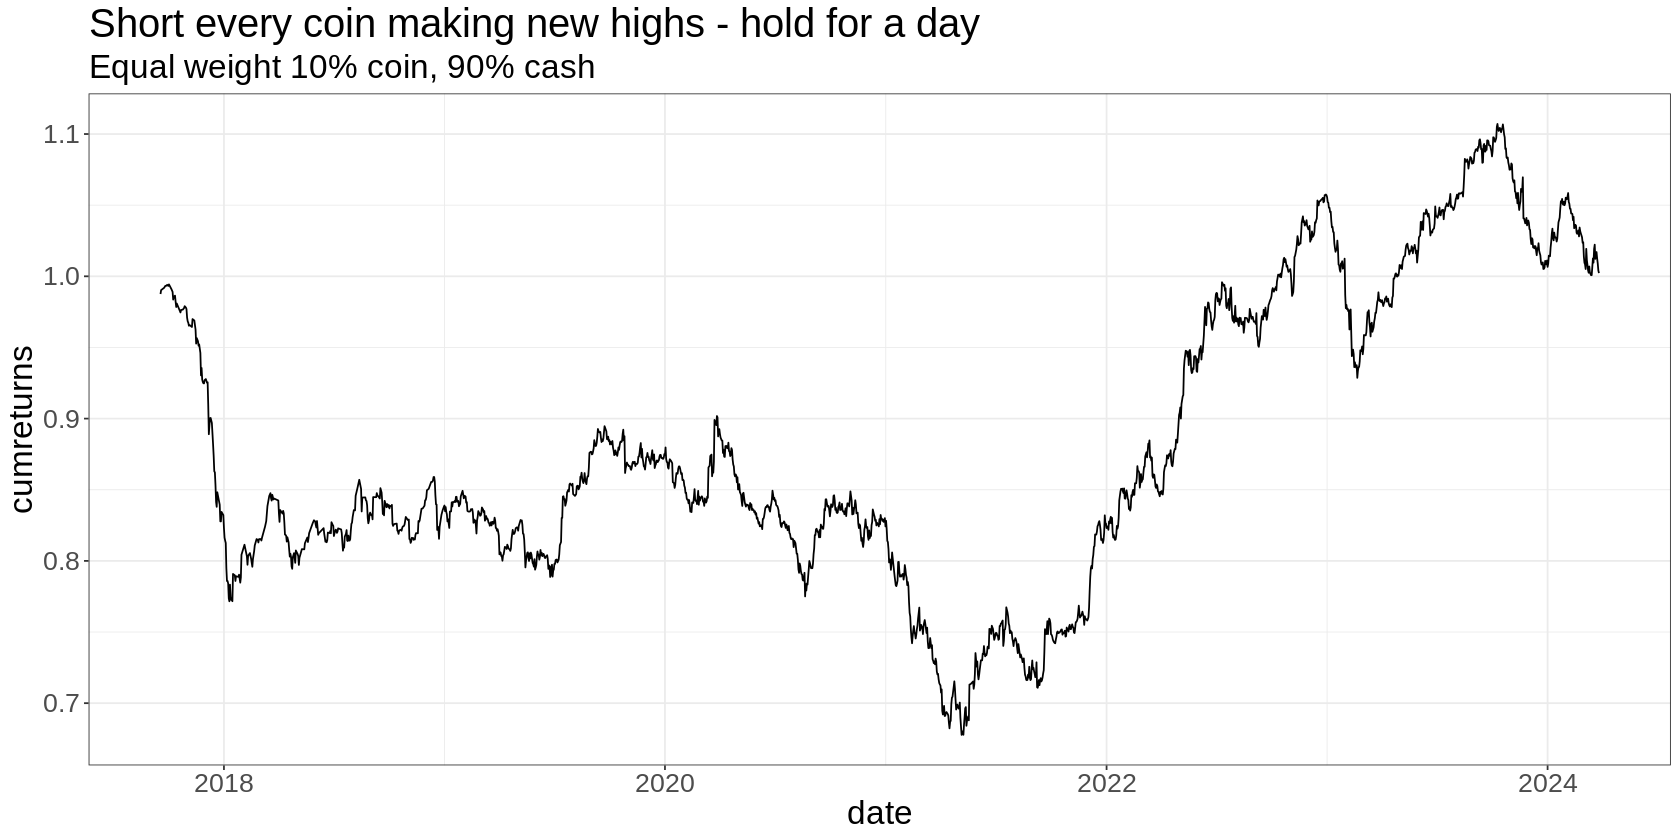

In [17]:
dsh %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = lead(price)/price-1) %>%
  na.omit() %>%
  filter(is_universe, dsh_3 == 0) %>%
  group_by(date) %>%
  summarize(mean_return = -mean(next_day_returns*0.1)) %>%
  mutate(cumreturns = cumprod(1+mean_return)) %>%
  ggplot(aes(x=date, y=cumreturns)) + geom_line() + ggtitle('Short every coin making new highs - hold for a day', subtitle = 'Equal weight 10% coin, 90% cash')



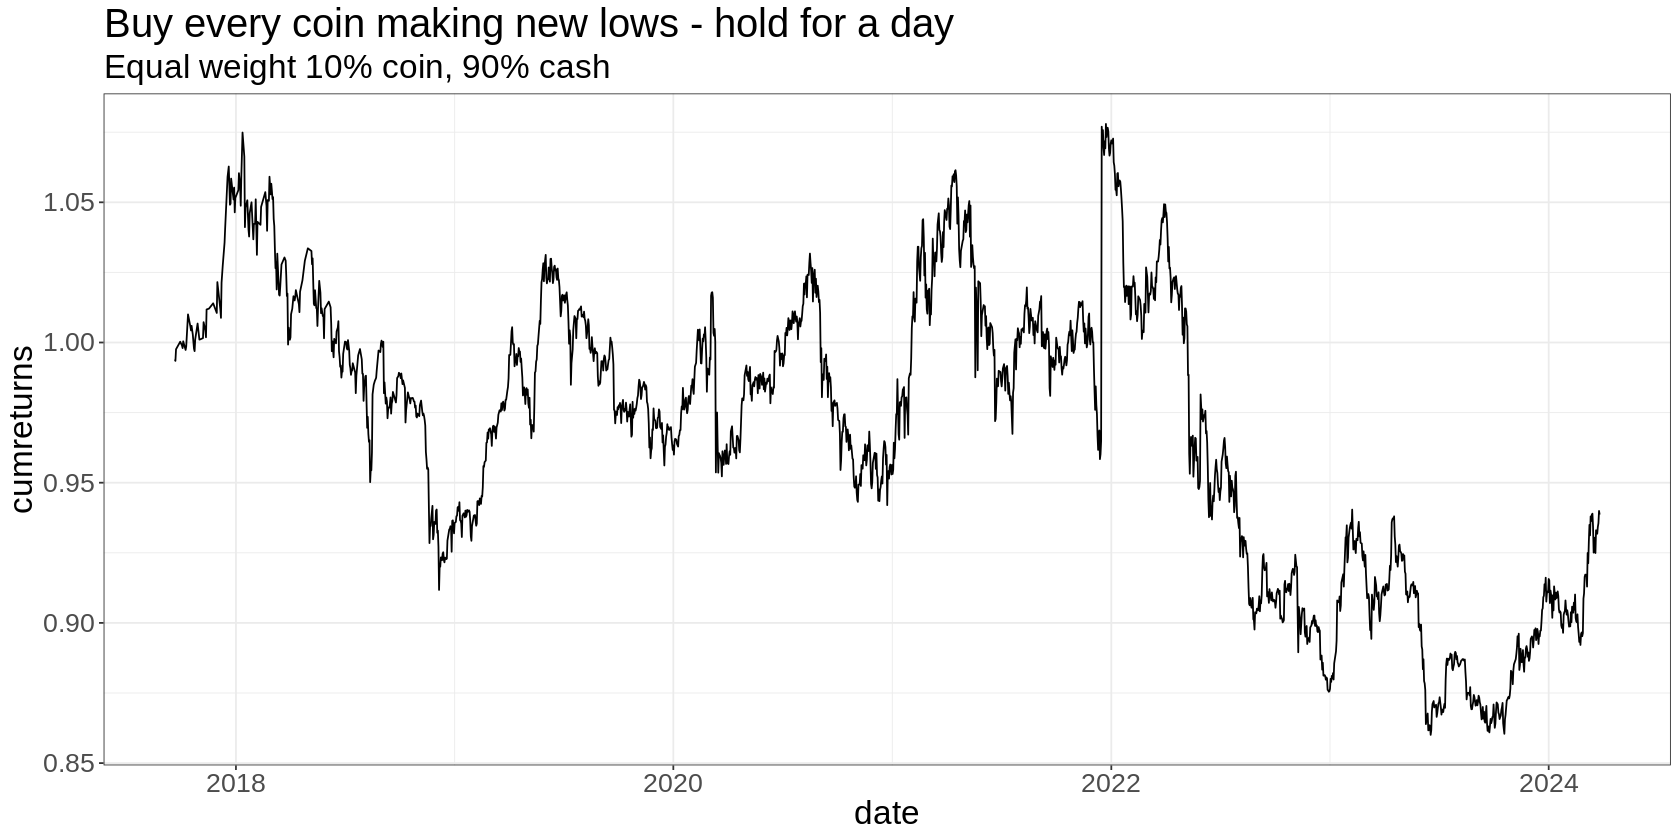

In [18]:
dsl %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = lead(price)/price-1) %>%
  na.omit() %>%
  filter(is_universe, dsl_3 == 0) %>%
  group_by(date) %>%
  summarize(mean_return = mean(next_day_returns*0.1)) %>%
  mutate(cumreturns = cumprod(1+mean_return)) %>%
  ggplot(aes(x=date, y=cumreturns)) + geom_line() + ggtitle('Buy every coin making new lows - hold for a day', subtitle = 'Equal weight 10% coin, 90% cash')

doesn't look great - but let's see if there's some relationship between this effect and liquidity... i'd expect to see more an effect in shittier stuff, for example.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 9 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”


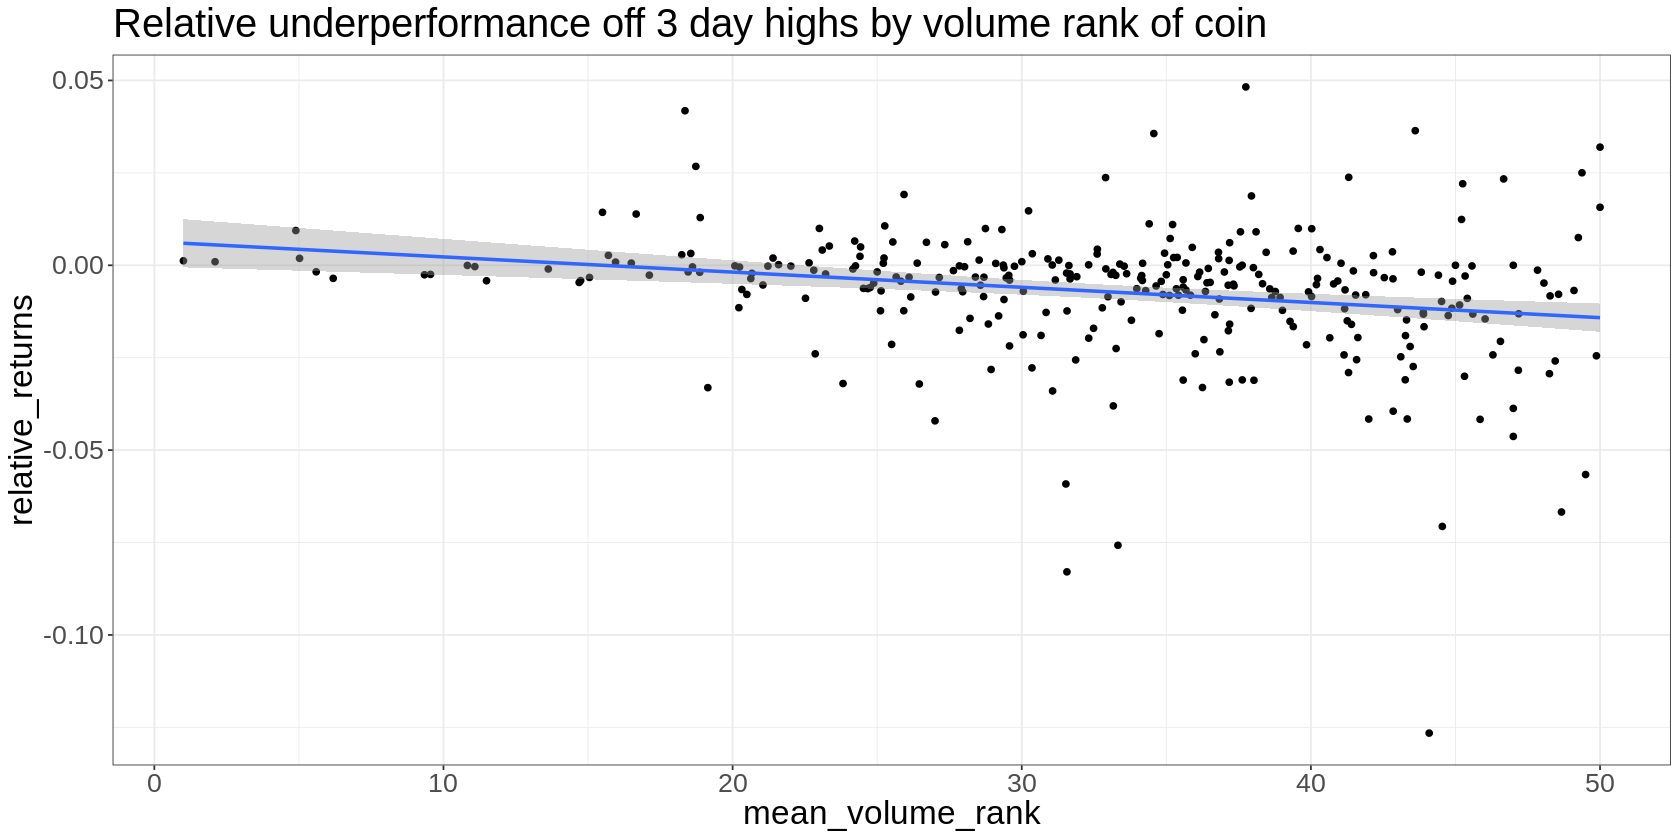

In [19]:
new_highs <- dsh %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = log(lead(price)/price)) %>%
  na.omit() %>%
  filter(is_universe) %>%
  filter(dsh_3 == 0) %>%
  summarize(new_high_returns = mean(next_day_returns))

avg <- dsh %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = log(lead(price)/price)) %>%
  na.omit() %>%
  filter(is_universe) %>%
  summarize(
    mean_return = mean(next_day_returns),
    mean_volume_rank = mean(volume_rank)
  )

avg %>%
  left_join(new_highs, by='Ticker') %>%
  mutate(relative_returns = new_high_returns - mean_return) %>%
  ggplot(aes(x=mean_volume_rank, y=relative_returns)) + geom_point() + geom_smooth(method='lm') + ggtitle('Relative underperformance off 3 day highs by volume rank of coin')

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


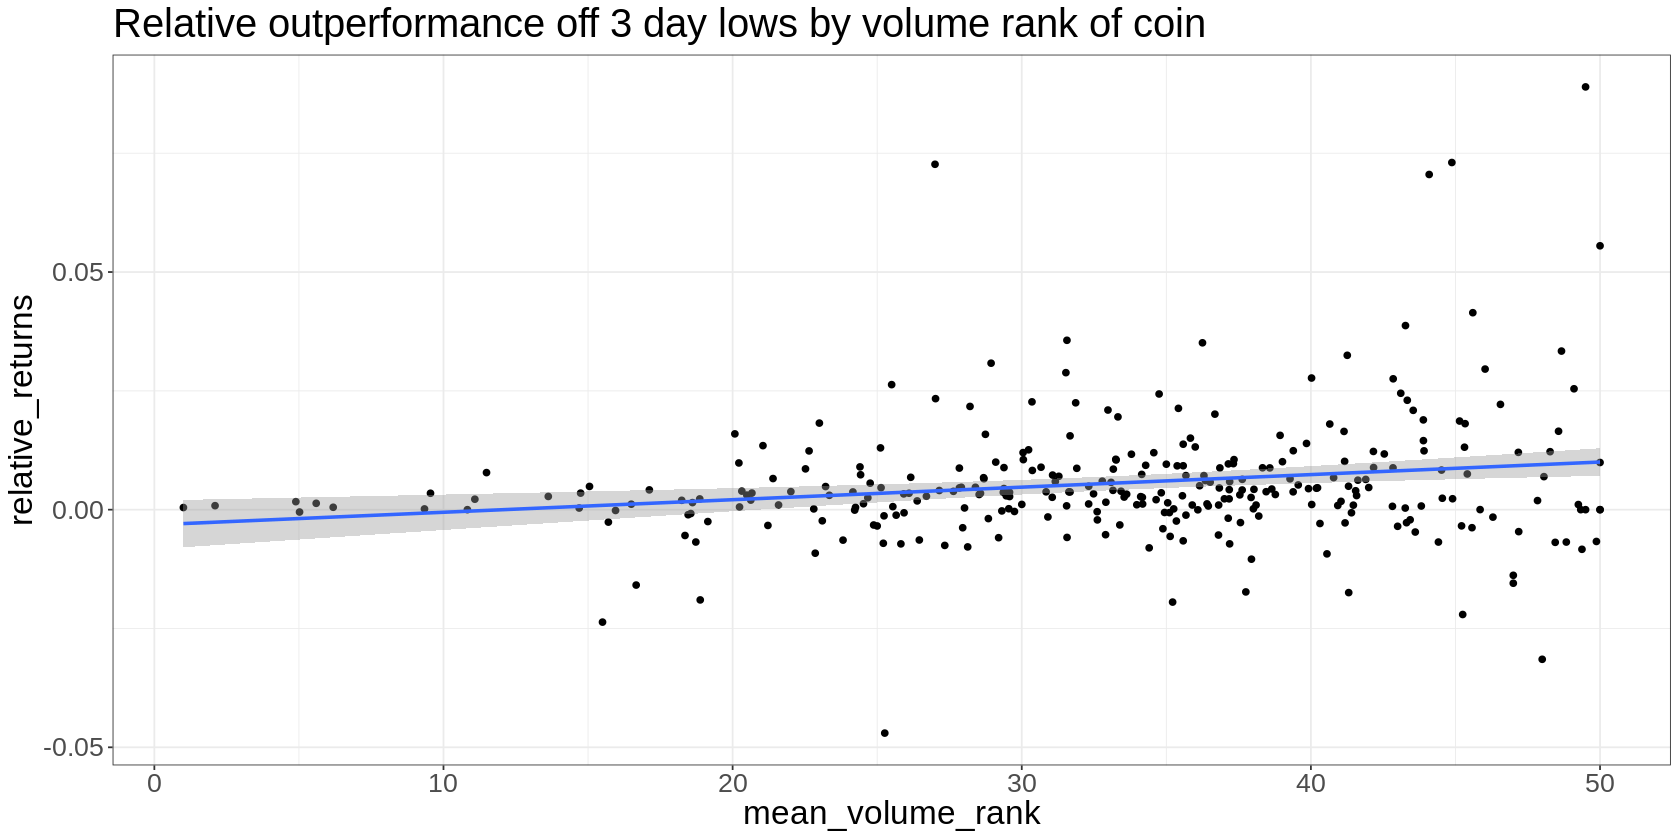

In [20]:
new_lows <- dsl %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = log(lead(price)/price)) %>%
  na.omit() %>%
  filter(is_universe) %>%
  filter(dsl_3 == 0) %>%
  summarize(new_high_returns = mean(next_day_returns))

avg <- dsl %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = log(lead(price)/price)) %>%
  na.omit() %>%
  filter(is_universe) %>%
  summarize(
    mean_return = mean(next_day_returns),
    mean_volume_rank = mean(volume_rank)
  )

avg %>%
  left_join(new_lows, by='Ticker') %>%
  mutate(relative_returns = new_high_returns - mean_return) %>%
  ggplot(aes(x=mean_volume_rank, y=relative_returns)) + geom_point() + geom_smooth(method='lm') + ggtitle('Relative outperformance off 3 day lows by volume rank of coin')

so what if we just traded the stuff in rank 40-60

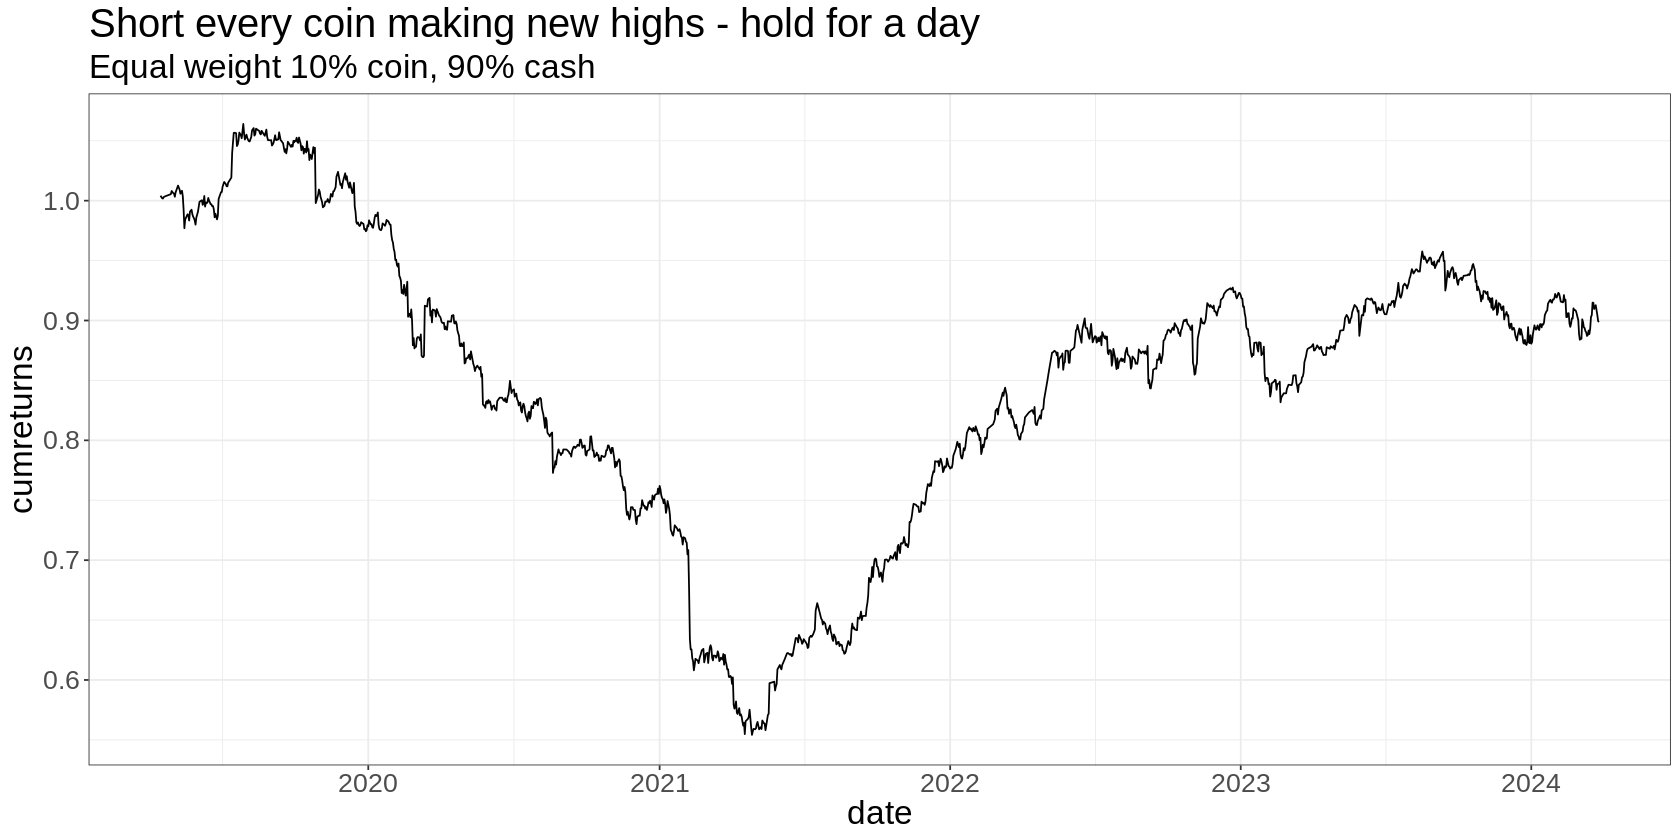

In [21]:
dsh %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = lead(price)/price-1) %>%
  na.omit() %>%
  filter(dsh_3 == 0, volume_rank >= 30, volume_rank <= 40) %>%
  group_by(date) %>%
  summarize(mean_return = -mean(next_day_returns*0.1)) %>%
  mutate(cumreturns = cumprod(1+mean_return)) %>%
  ggplot(aes(x=date, y=cumreturns)) + geom_line() + ggtitle('Short every coin making new highs - hold for a day', subtitle = 'Equal weight 10% coin, 90% cash')

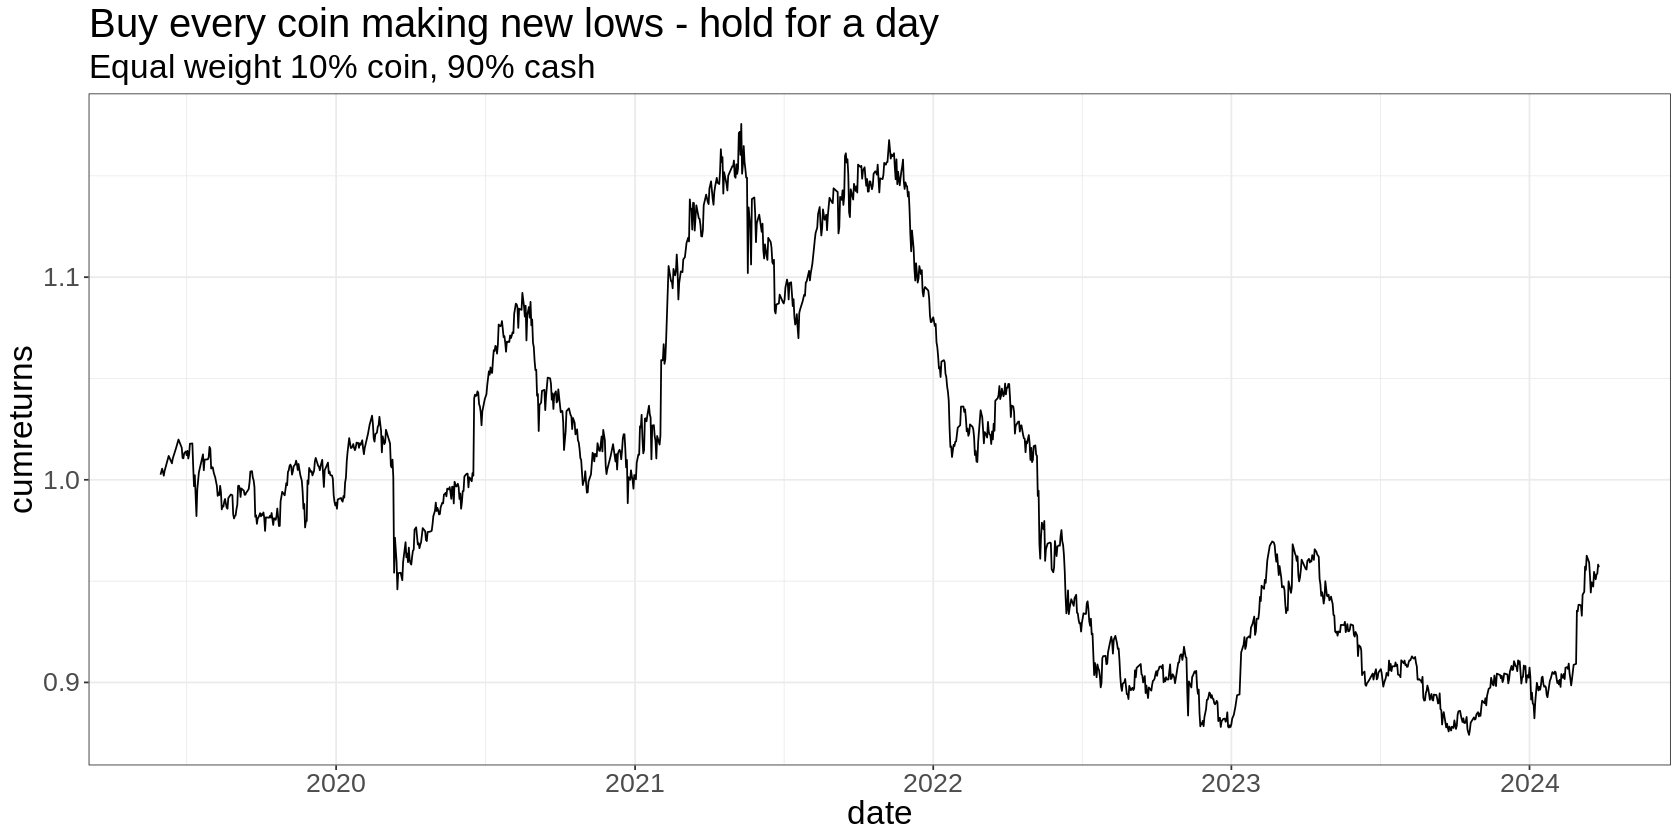

In [22]:
dsl %>%
  group_by(Ticker) %>%
  mutate(next_day_returns = lead(price)/price-1) %>%
  na.omit() %>%
  filter(is_universe, dsl_3 == 0, volume_rank >= 40, volume_rank <= 60) %>%
  group_by(date) %>%
  summarize(mean_return = mean(next_day_returns*0.1)) %>%
  mutate(cumreturns = cumprod(1+mean_return)) %>%
  ggplot(aes(x=date, y=cumreturns)) + geom_line() + ggtitle('Buy every coin making new lows - hold for a day', subtitle = 'Equal weight 10% coin, 90% cash')

# Price Range Analysis

This is a bit of a crude feature. Let's look at whether the price range is helpful.

We take another approach and look at the correlation of future returns with our signal.

This is a little hard to explain here - so watch the webinar for context if it's not clear what i'm doing.

In [24]:
lookbacks <- c(3,6,12,18,24)

ibs_IC <- function(lookback) {
  universe %>%
    group_by(Ticker) %>%
    arrange(Datetime) %>%
    mutate(
      ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
      fwd_return_0 = log(lead(Close, 1) / Close),
      fwd_return_1 = log(lead(Close, 2) / lead(Close, 1)),
      fwd_return_2 = log(lead(Close, 3) / lead(Close, 2)),
      fwd_return_3 = log(lead(Close, 4) / lead(Close, 3)),
      fwd_return_4 = log(lead(Close, 5) / lead(Close, 4)),
      fwd_return_5 = log(lead(Close, 6) / lead(Close, 5)),
      fwd_return_6 = log(lead(Close, 7) / lead(Close, 6)),
      fwd_return_7 = log(lead(Close, 8) / lead(Close, 7)),
      fwd_return_8 = log(lead(Close, 9) / lead(Close, 8)),
      fwd_return_9 = log(lead(Close, 10) / lead(Close, 9)),
      fwd_return_10 = log(lead(Close, 11) / lead(Close, 10)),
      fwd_return_11 = log(lead(Close, 12) / lead(Close, 11)),
      fwd_return_12 = log(lead(Close, 13) / lead(Close, 12))
    ) %>%
    filter(is_universe, lubridate::hour(Datetime) == 0) %>% # take out some of the overlaps to keep data smaller
    na.omit() %>%
      pivot_longer(
      cols = starts_with("fwd_return_"),
      names_to = "fwd_window",
      names_prefix = "fwd_return_",
      values_to = "returns"
    ) %>%
    mutate(
      fwd_window = as.integer(fwd_window)  # Convert fwd_window to integer if necessary
    ) %>%
    group_by(fwd_window) %>%
    summarize(IC = cor(ibs,returns)) %>%
    mutate(lookback = lookback)
}

ibsic <- do.call(rbind, lapply(lookbacks, ibs_IC))

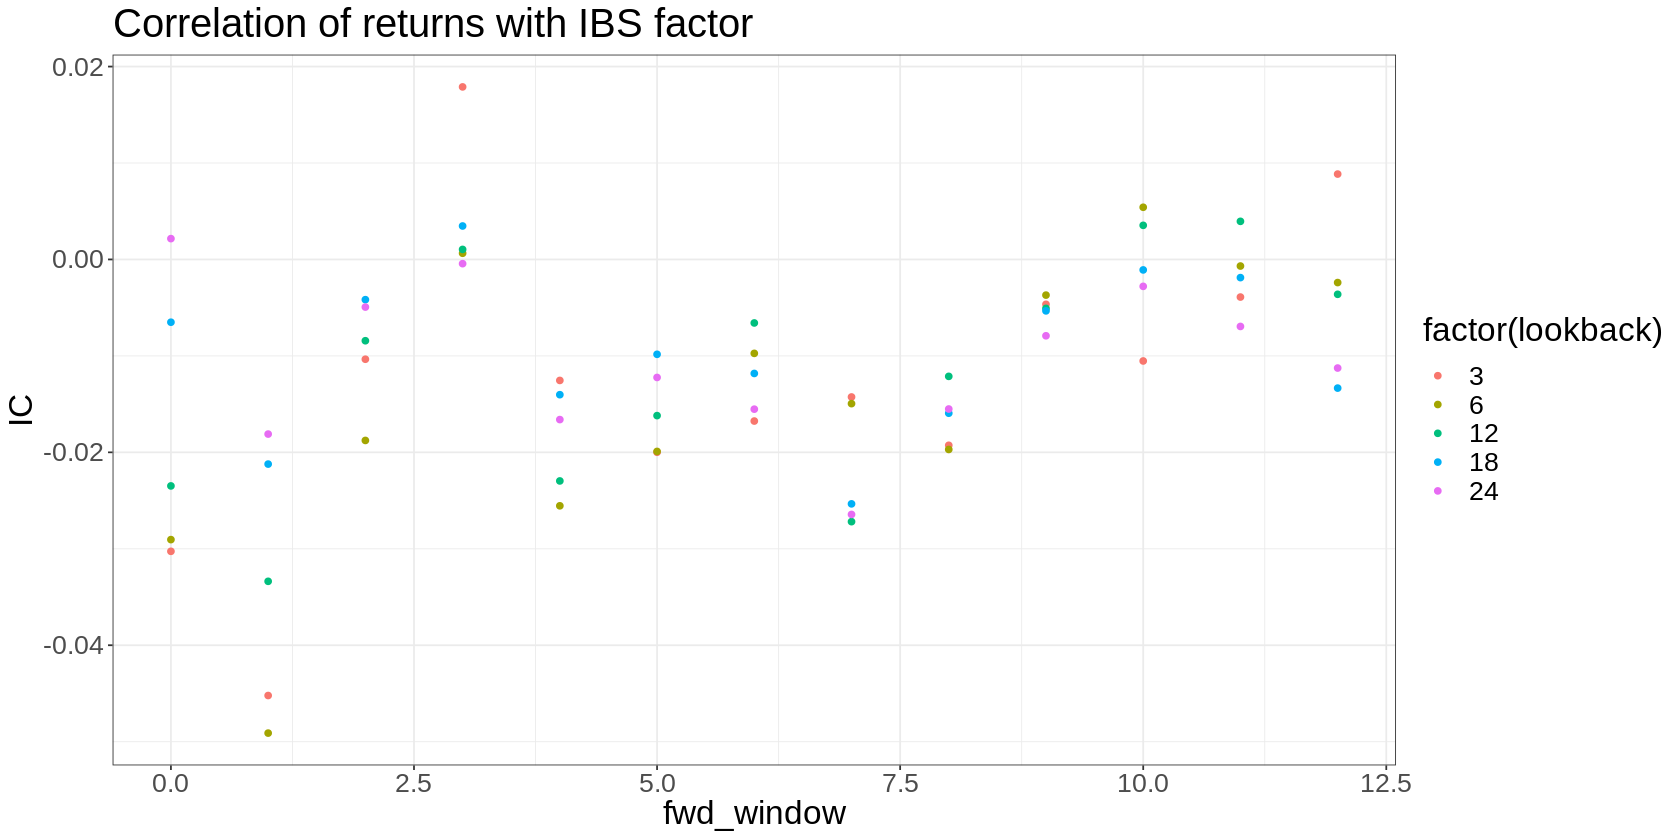

In [25]:
ibsic %>%
  ggplot(aes(x=fwd_window, y=IC, color = factor(lookback))) + geom_point() + ggtitle('Correlation of returns with IBS factor')

we see correlations are generally negative 0 which we want.

and we see the effect is pretty much over after 12 hours.

we assumed the relationship was linear. lets zoom in on the 6m 1-2h point (the second brown-green dot on the plot)

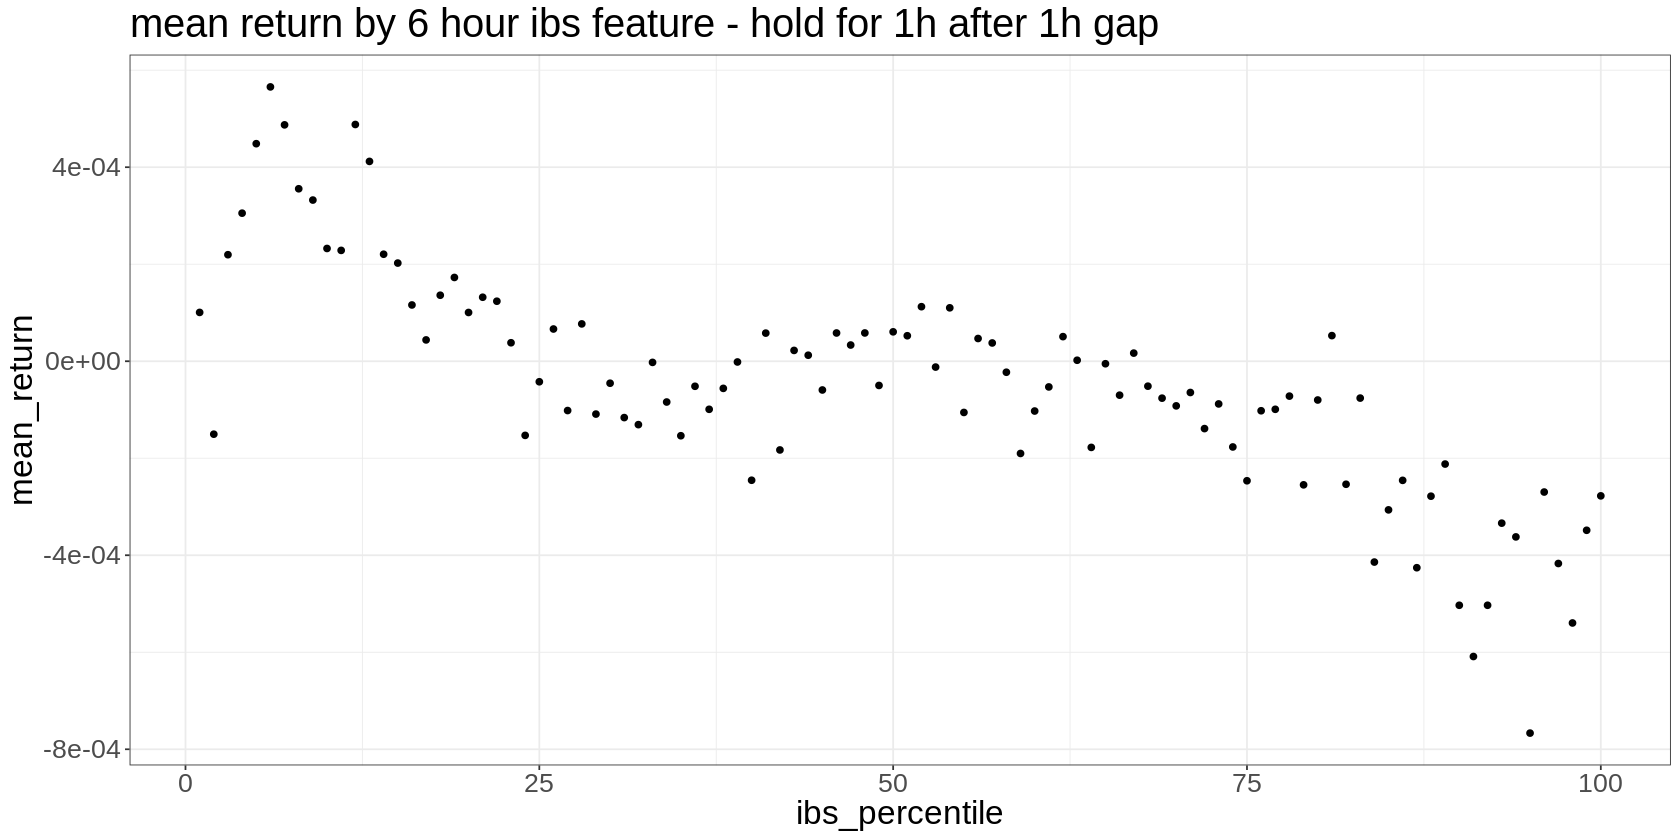

In [26]:
lookback <- 6

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, 2) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  filter(is_universe) %>%
  mutate(ibs_percentile = ntile(ibs, 100)) %>%
  group_by(ibs_percentile) %>%
  summarize(mean_return = mean(fwd_return)) %>%
  ggplot(aes(x=ibs_percentile, y=mean_return)) + geom_point() + ggtitle(glue('mean return by {lookback} hour ibs feature - hold for 1h after 1h gap'))


kinda roughly linear. interesting left tail stuff. pukey stuff seems to die off new lows - similar to stocks. not that surprising. we'll ignore that for now?

could we put together some kind of strategy?

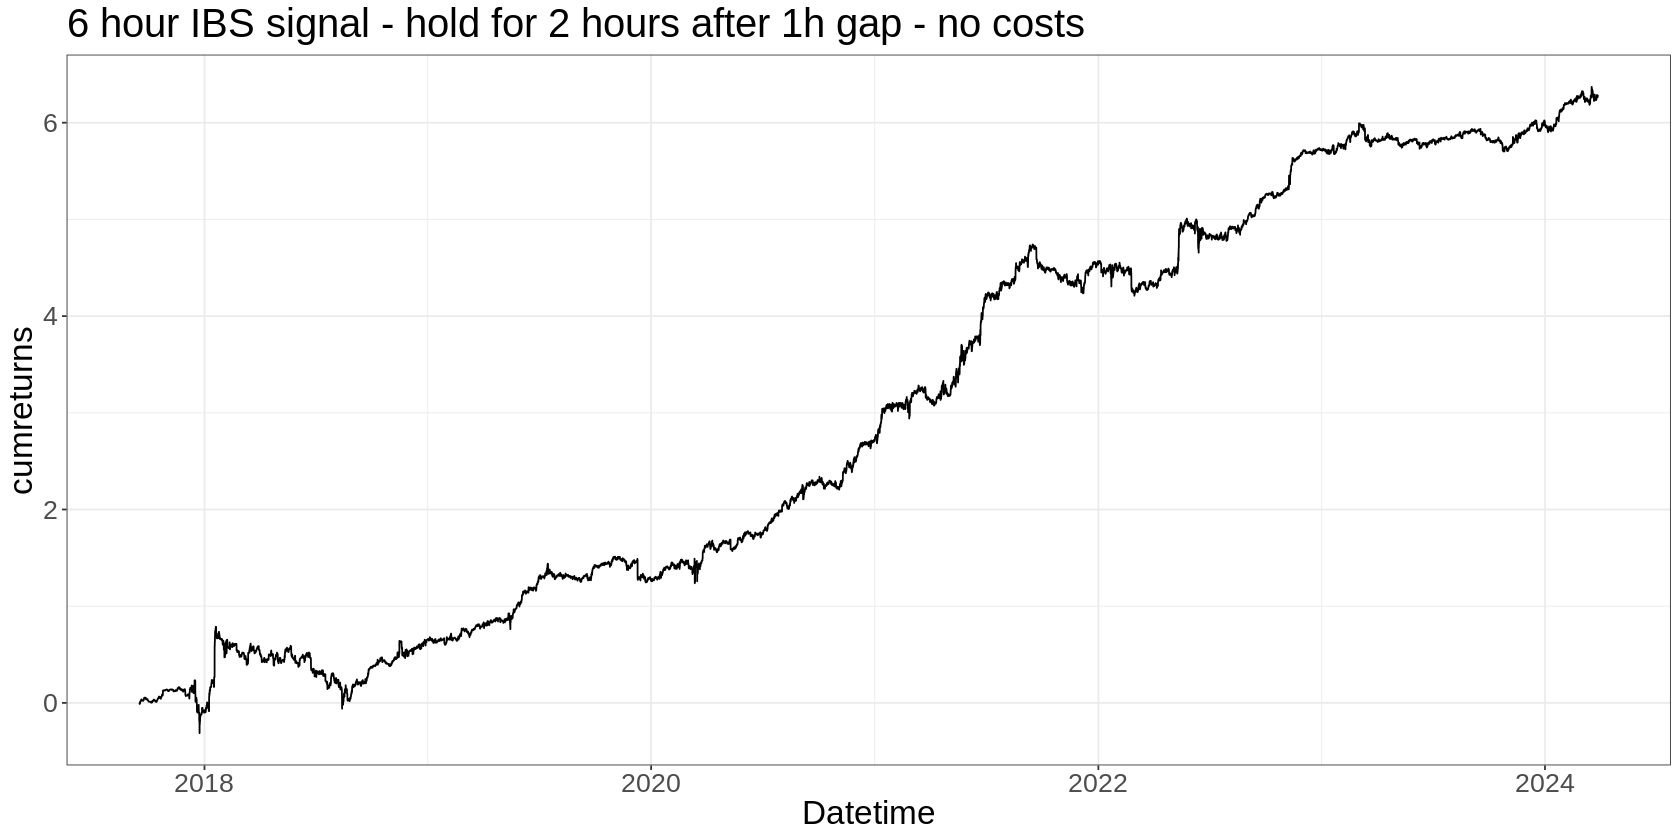

In [27]:
lookback <- 6
hold_period <- 2

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, hold_period + 1) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  # remove the overlaps
  filter(row_number() %% lookback == 0) %>%
  filter(is_universe) %>%
  mutate(ibs_decile = ntile(ibs, 10)) %>%
  mutate(returns = case_when(ibs_decile == 1 ~ fwd_return, ibs_decile == 10 ~ -fwd_return, TRUE ~ 0)) %>%
  group_by(Datetime) %>%
  summarize(mean_returns = mean(exp(returns) - 1)) %>%
  arrange(Datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=Datetime, y=cumreturns)) + geom_line() + ggtitle('6 hour IBS signal - hold for 2 hours after 1h gap - no costs')


looks good ofc... but this would be crazy active and therefore really expensive to trade.

if we estimate cheapish costs @ 0.05% of amount traded, what does it look like?

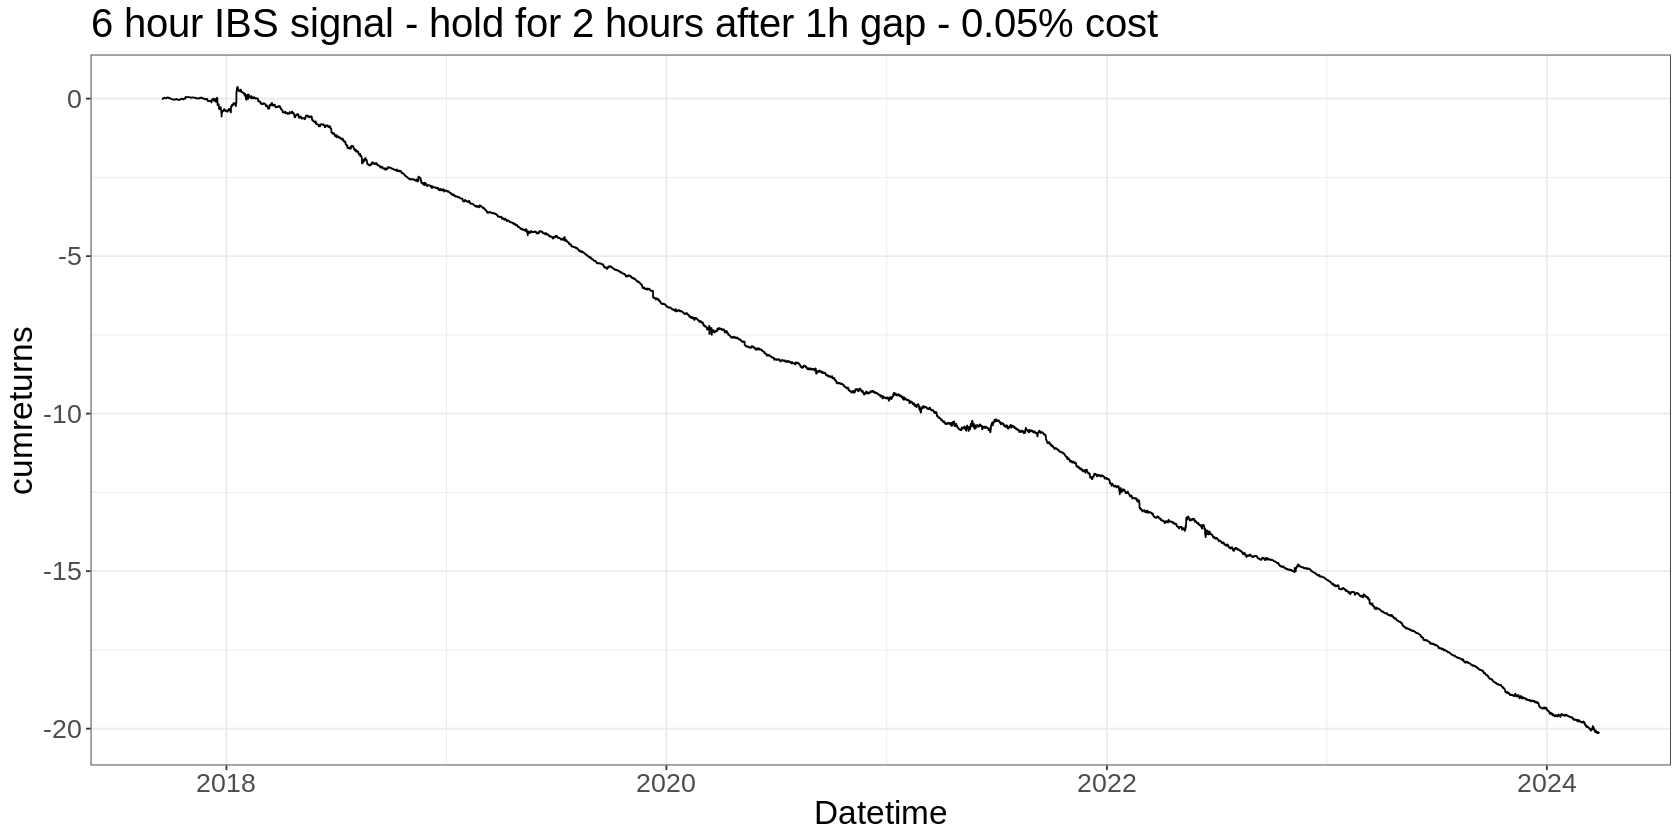

In [28]:
cost <- 0.05/100
lookback <- 6
hold_period <- 2

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, hold_period + 1) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  # remove the overlaps
  filter(row_number() %% lookback == 0) %>%
  filter(is_universe) %>%
  mutate(ibs_decile = ntile(ibs, 10)) %>%
  mutate(returns = case_when(ibs_decile == 1 ~ fwd_return, ibs_decile == 10 ~ -fwd_return, TRUE ~ 0)) %>%
  group_by(Datetime) %>%
  summarize(mean_returns = mean(exp(returns) - 1 - cost)) %>%
  arrange(Datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=Datetime, y=cumreturns)) + geom_line() + ggtitle('6 hour IBS signal - hold for 2 hours after 1h gap - 0.05% cost')

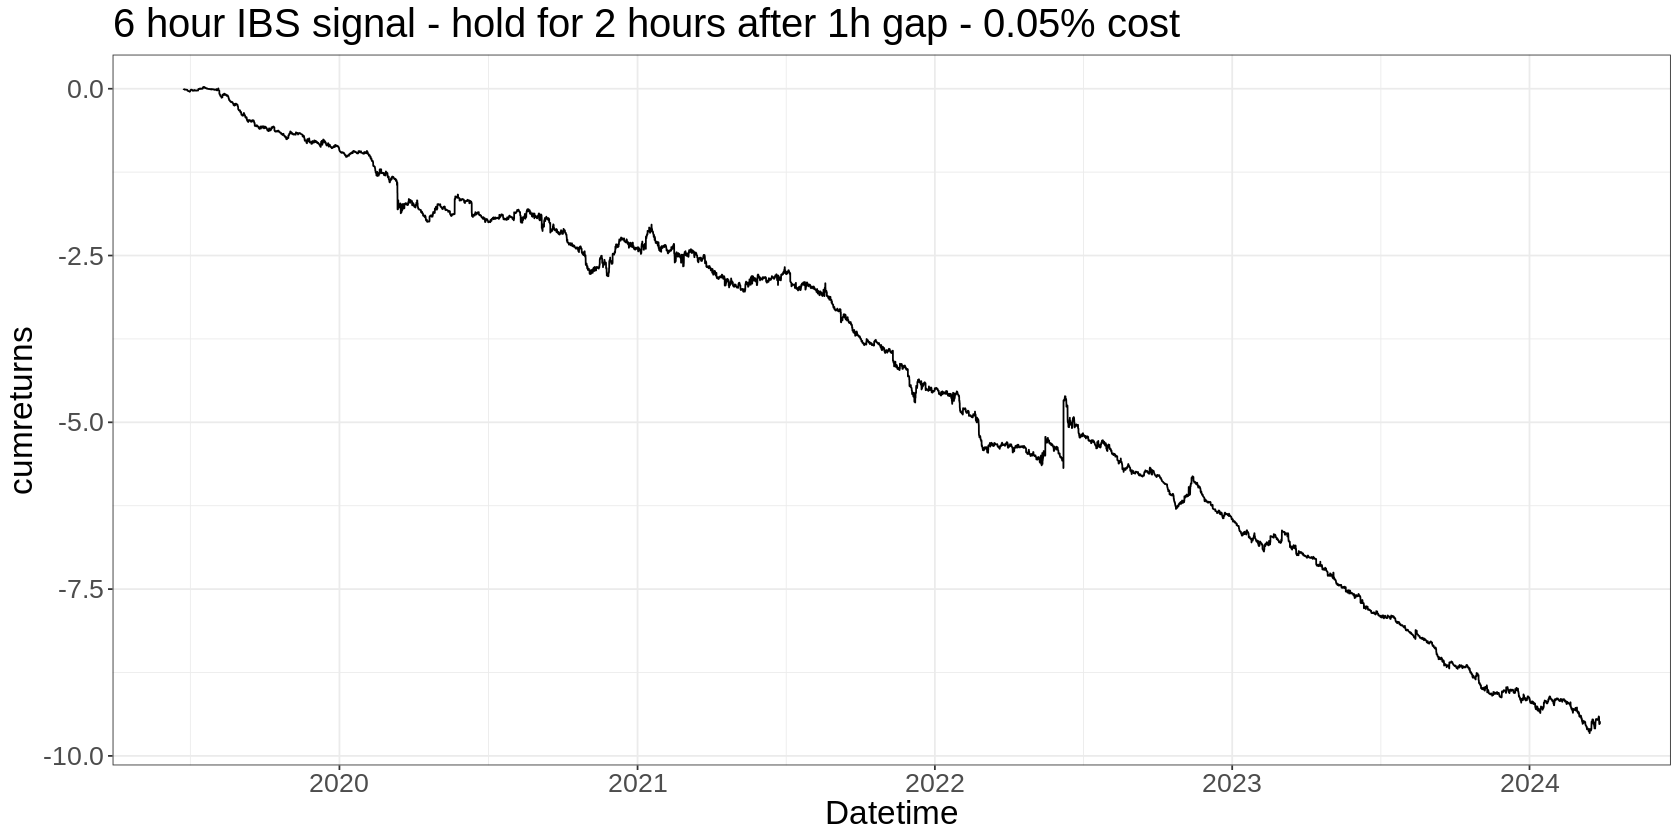

In [29]:
cost <- 0.05/100
lookback <- 6
hold_period <- 2

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, hold_period + 1) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  # remove the overlaps
  filter(row_number() %% lookback == 0) %>%
  filter(is_universe) %>%
  filter(volume_rank > 40) %>%
  mutate(ibs_decile = ntile(ibs, 10)) %>%
  mutate(returns = case_when(ibs_decile == 1 ~ fwd_return, ibs_decile == 10 ~ -fwd_return, TRUE ~ 0)) %>%
  group_by(Datetime) %>%
  summarize(mean_returns = mean(exp(returns) - 1 - cost)) %>%
  arrange(Datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=Datetime, y=cumreturns)) + geom_line() + ggtitle('6 hour IBS signal - hold for 2 hours after 1h gap - 0.05% cost')

Trading slower kinda essential then?

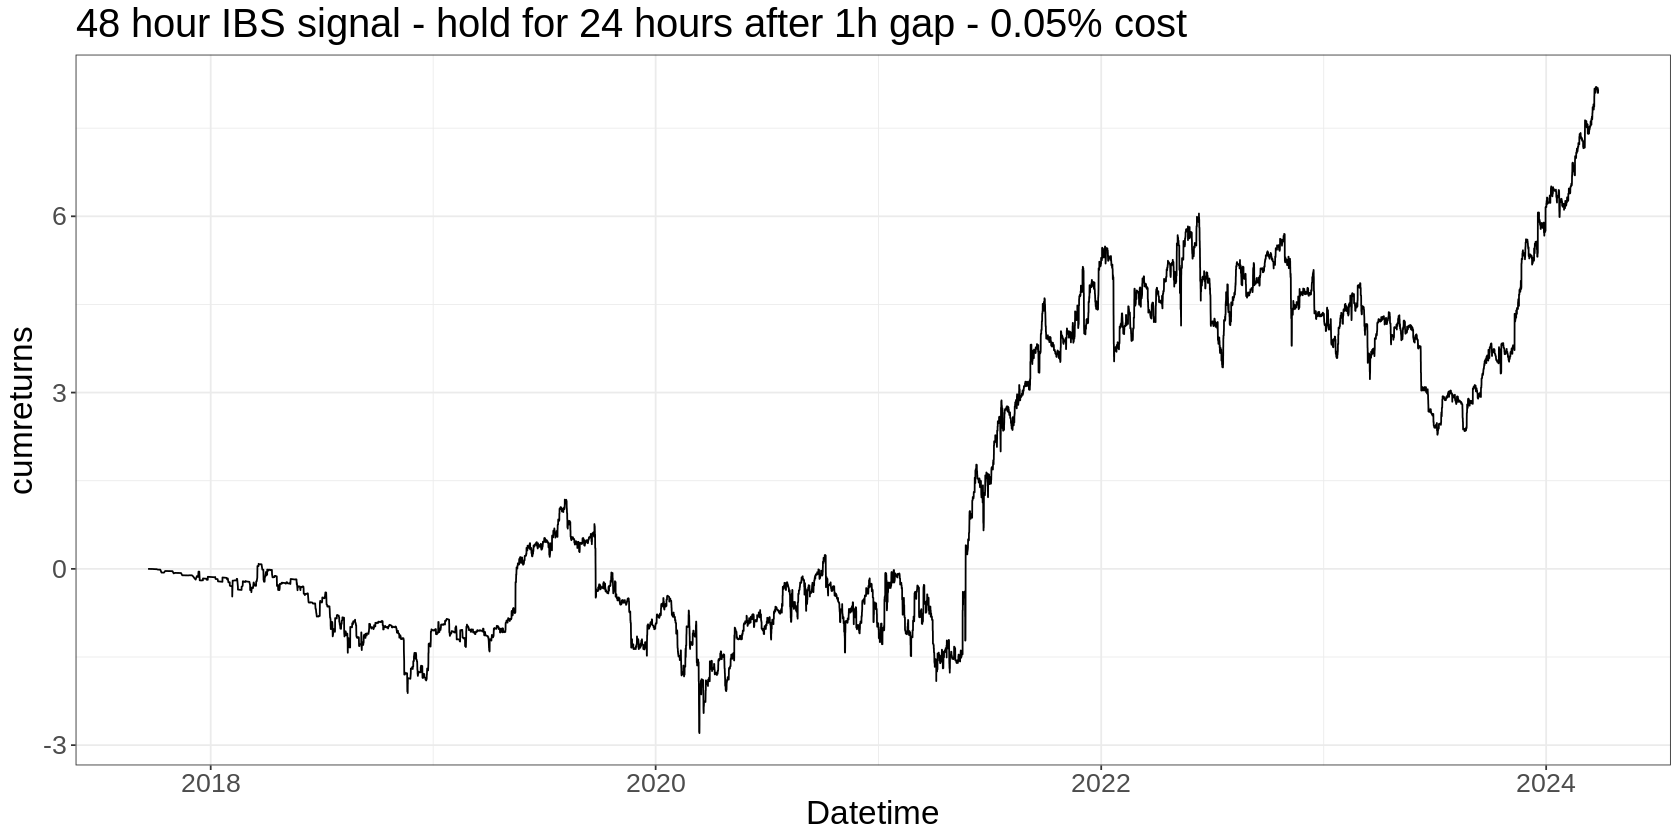

In [30]:
cost <- 0.05/100
lookback <- 48
hold_period <- 24

universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    ibs = (Close - roll::roll_min(Low, lookback)) / (roll::roll_max(High, lookback) - roll::roll_min(Low, lookback)),
    fwd_return= log(lead(Close, hold_period + 1) / lead(Close, 1))
  ) %>%
  na.omit() %>%
  # remove the overlaps
  filter(row_number() %% lookback == 0) %>%
  filter(is_universe) %>%
  # filter(volume_rank > 40) %>%
  mutate(ibs_decile = ntile(ibs, 10)) %>%
  mutate(returns = case_when(ibs_decile == 1 ~ fwd_return, ibs_decile == 10 ~ -fwd_return, TRUE ~ 0)) %>%
  group_by(Datetime) %>%
  summarize(mean_returns = mean(exp(returns) - 1 - cost)) %>%
  arrange(Datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=Datetime, y=cumreturns)) + geom_line() + ggtitle('48 hour IBS signal - hold for 24 hours after 1h gap - 0.05% cost')

you can make something that worked in the past, but it's not super compelling.

this is a real effect tho - and something that could be useful for timing trades into longer term positions.